This notebook may be used as a start for your exploration of time series analysis using multi-layer neural network, which weights are selected with NSGA-II algorithm with respect to two opposite criteria (objectives) of PICP and PINRW.

X.csv and F.csv in this folder contain the computed solution vectors as well as objectives values, where 1-PICP is the first column, PINRW is the second column.

The authors are:

Chervyakov A. - problem statement and analysis, methodology. <br>
Nikulchev E. - results validation and criticism. <br>
Gusev A. - data analysis, pipeline construction, code writing, tuning and testing. <br>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


2024-02-26 09:39:14.702140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 09:39:14.702296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 09:39:15.101527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 09:39:17.086182: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-26 09:39:26.438193: W tensorflow/compiler/tf2

In [3]:
!pip show pymoo || pip install pymoo
from pymoo.core.problem import ElementwiseProblem


     |████████████████████████████████| 4.1 MB 641 kB/s eta 0:00:01
     |████████████████████████████████| 249 kB 31.2 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 1.2 MB/s  eta 0:00:01
     |████████████████████████████████| 116 kB 12.4 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 948 kB/s  eta 0:00:01
     |████████████████████████████████| 491 kB 40.0 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 35.1 MB/s eta 0:00:01
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=7cf55f4e48e87768c90a9d5a28dcae374749c6203897b45a5368f2a292b1375f
  Stored in directory: /home/alexander/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [4]:
import tensorflow as tf
import math
tf.executing_eagerly()

True

In [14]:
#load the data

data = pd.read_csv('HistoricalData_1708930288397.csv',
                   header=0,
                   usecols=['Date', 'Close/Last'],
                   parse_dates=['Date'],
                   date_format='%m/%d/%Y')

df = data[['Date', 'Close/Last']].copy()


In [15]:
df = df.sort_values('Date')
df = df.reset_index(drop=True)



In [16]:
df.head()

,Date,Close/Last
0,2014-02-26,1845.16
1,2014-02-27,1854.29
2,2014-02-28,1859.45
3,2014-03-03,1845.73
4,2014-03-04,1873.91


In [17]:
df.tail()

,Date,Close/Last
2526,2024-02-16,5005.57
2527,2024-02-20,4975.51
2528,2024-02-21,4981.80
2529,2024-02-22,5087.03
2530,2024-02-23,5088.80


In [18]:
def PICP(y_true, y_pred):

    n = tf.shape(y_pred)[0]
    c = tf.TensorArray(dtype=tf.float32, size=n)

    for i in tf.range(n):
        if y_true[i] >= y_pred[i][0] and y_true[i] <= y_pred[i][1]:
            c = c.write(i, 1.0)
        else:
            c = c.write(i, 0.0)

    return tf.reduce_sum(c.stack()) / tf.cast(n, dtype=tf.float32)

In [19]:
def PINRW(y_pred, R = 1.00):
    n = tf.shape(y_pred)[0]
    sum_of_squared_diff = tf.reduce_sum(tf.square(y_pred[:, 1] - y_pred[:, 0]))
    return tf.sqrt(sum_of_squared_diff / tf.cast(n, dtype=tf.float32)) / R


In [20]:
df.tail()

,Date,Close/Last
2526,2024-02-16,5005.57
2527,2024-02-20,4975.51
2528,2024-02-21,4981.80
2529,2024-02-22,5087.03
2530,2024-02-23,5088.80


In [21]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

In [22]:
df[:train_size].tail()

,Date,Close/Last
2019,2022-02-09,4587.18
2020,2022-02-10,4504.08
2021,2022-02-11,4418.64
2022,2022-02-14,4401.67
2023,2022-02-15,4471.07


In [23]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['Close/Last'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['Close/Last'].values.reshape(-1, 1))

In [24]:
X_test = test_scaled[:-6]
y_test = test_scaled[11:]

In [25]:
X_train = train_scaled[:-6]
y_train = train_scaled[11:]

In [26]:
X_train = np.hstack((X_train[:-5], X_train[1:-4], X_train[2:-3], X_train[3:-2], X_train[4:-1], X_train[5:]))
X_test = np.hstack((X_test[:-5], X_test[1:-4], X_test[2:-3], X_test[3:-2], X_test[4:-1], X_test[5:]))

In [27]:
X_train.shape

(2013, 6)

In [28]:
y_train.shape

(2013, 1)

In [29]:
X_test.shape

(496, 6)

In [30]:
y_test.shape

(496, 1)

In [31]:
# Define the model
model = Sequential([
    Dense(units=6),
    Dense(units=3),
    Dense(units=2)
])

# Build the model
input_shape = X_train.shape[1:]
model.build((None, *input_shape))

def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes
def set_shape(weights,shapes):
    new_weights = []
    index=0
    for shape in shapes:
        if(len(shape)>1):
            n_nodes = np.prod(shape)+index
        else:
            n_nodes=shape[0]+index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index=n_nodes
    return new_weights

2024-02-26 09:53:35.666603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 09:53:37.695816: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-26 09:53:37.696390: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [32]:
shape = get_shape(model)

In [33]:
model.count_params()

71

In [34]:
class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=model.count_params(),
                         n_obj=2,
                         xl=np.full(model.count_params(), -1),
                         xu=np.full(model.count_params(), 1)
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        global model, shape, X_train, y_train
        model.set_weights(set_shape(x,shape))
        predictions = model.predict(X_train)
        f1 = 1 - PICP(y_train, predictions)
        f2 = PINRW(predictions)

        out["F"] = [f1, f2]

problem = MyProblem()

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
Total params: 71 (284.00 Byte)
Trainable params: 71 (284.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=model.count_params() + 2,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)



In [37]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 500)

In [38]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

63/63 [==============================] - 1s 1ms/step


2024-02-26 09:53:59.007738: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


63/63 [==============================] - 0s 923us/step
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       73 |      4 |             - |             -
63/63 [==============================] - 0s 838us/step
     2 |       83 |      4 |  0.3390857943 |         nadir
63/63 [==============================] - 0s 1ms/step
     3 |       93 |      6 |  0.0627830047 |             f
63/63 [==============================] - 0s 941us/step
     4 |      103 |      6 |  0.0279061051 |         nadir
63/63 [==============================] - 0s 857us/step
     5 |      113 |      7 |  0.0349494555 |             f
63/63 [==============================] - 0s 913us/step
     6 |      123 |      7 |  0.0335449121 |             f
63/63 [==============================] - 0s 791us/step
     7 |      133 |      7 |  0.000000E+00 |             f
63/63 [==============================] - 0s 993us/step
     8 |      143 |      7 |  0.000000E+00 |             f
63/63 [========================

In [39]:
X_df = pd.DataFrame(X)

In [40]:
F_df = pd.DataFrame(F)

In [42]:
X_df.to_csv('6_days_ahead_X_S&P.csv')

In [43]:
F_df.to_csv('6_days_ahead_F_S&P.csv')

In [48]:
F_df = pd.read_csv('6_days_ahead_F.csv')
F = np.array(F_df.iloc[:,1:])
X_df = pd.read_csv('6_days_ahead_X.csv')
X = np.array(X_df.iloc[:,1:])

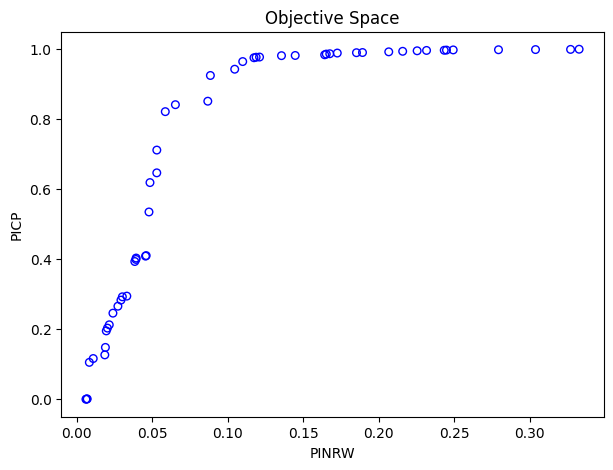

In [44]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 1], 1 - F[:, 0], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.xlabel('PINRW')
plt.ylabel('PICP')
plt.show()

In [45]:
y_test_unscaled = scaler.inverse_transform(y_test)

<H1> Predictions section:

In [46]:
from matplotlib.backends.backend_pdf import PdfPages

In [56]:
X_val = X_test[:-6]
y_val = y_test[:-6]

X_future = X_test[-6:]
last_dates = df['Date'].tail(6)
y_future = y_test_unscaled[-6:]

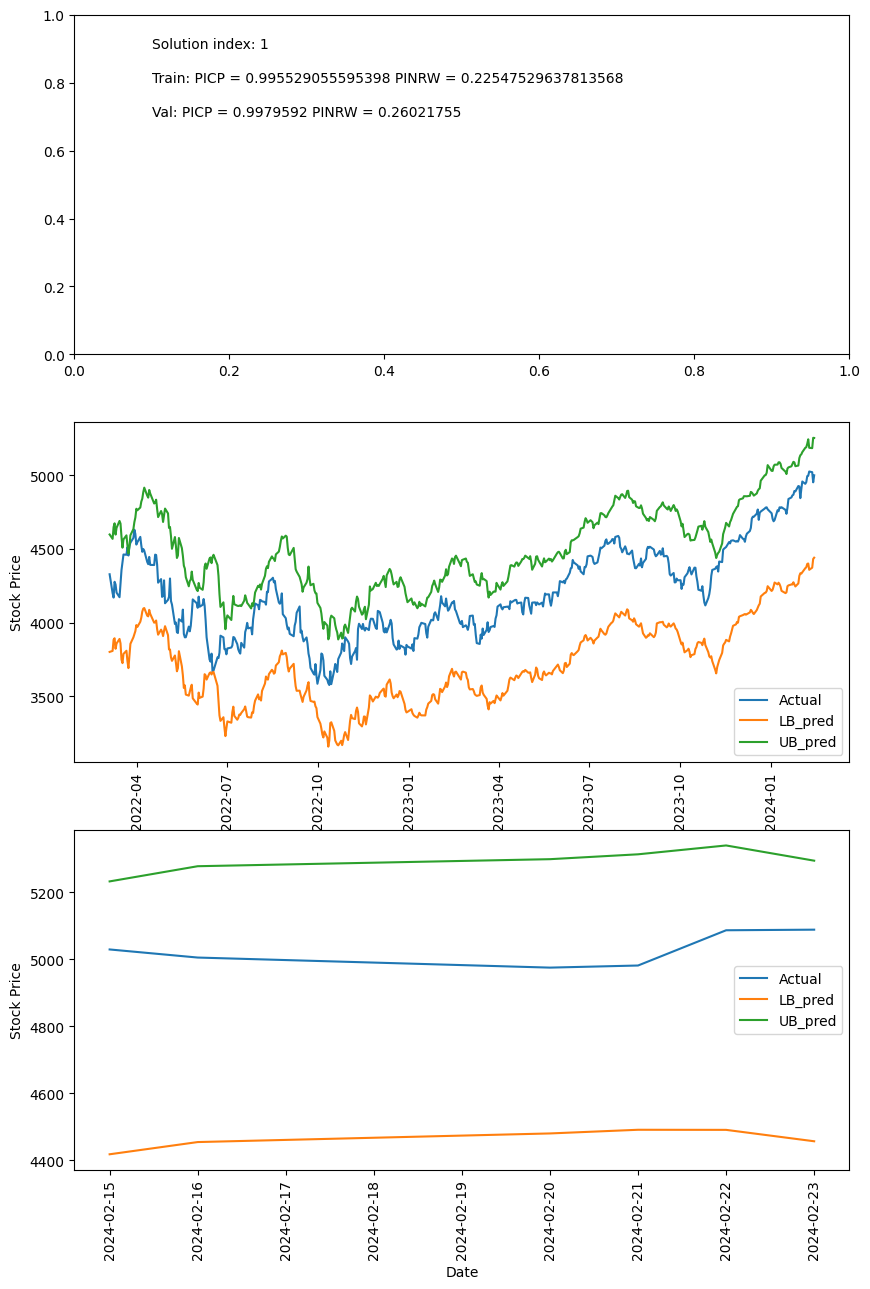

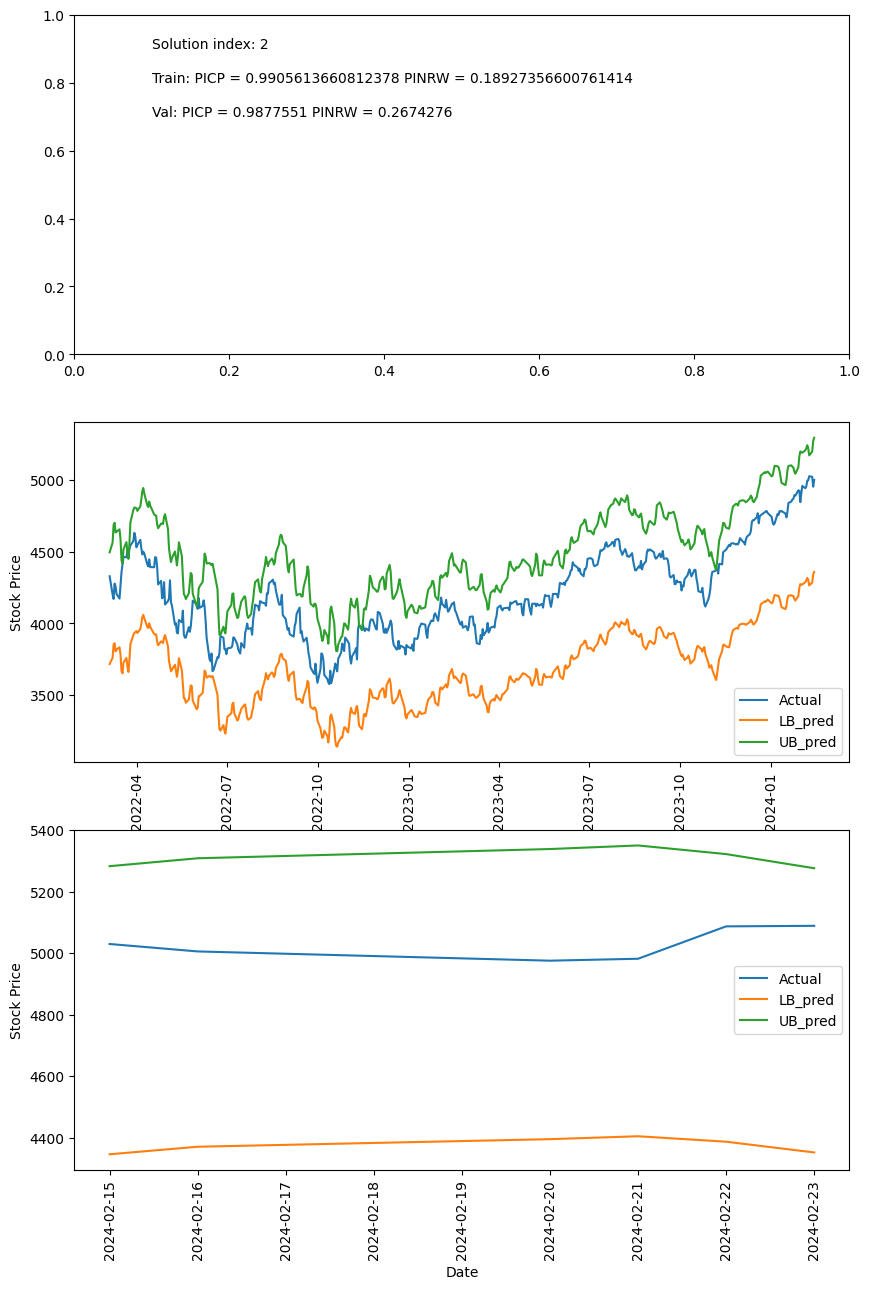

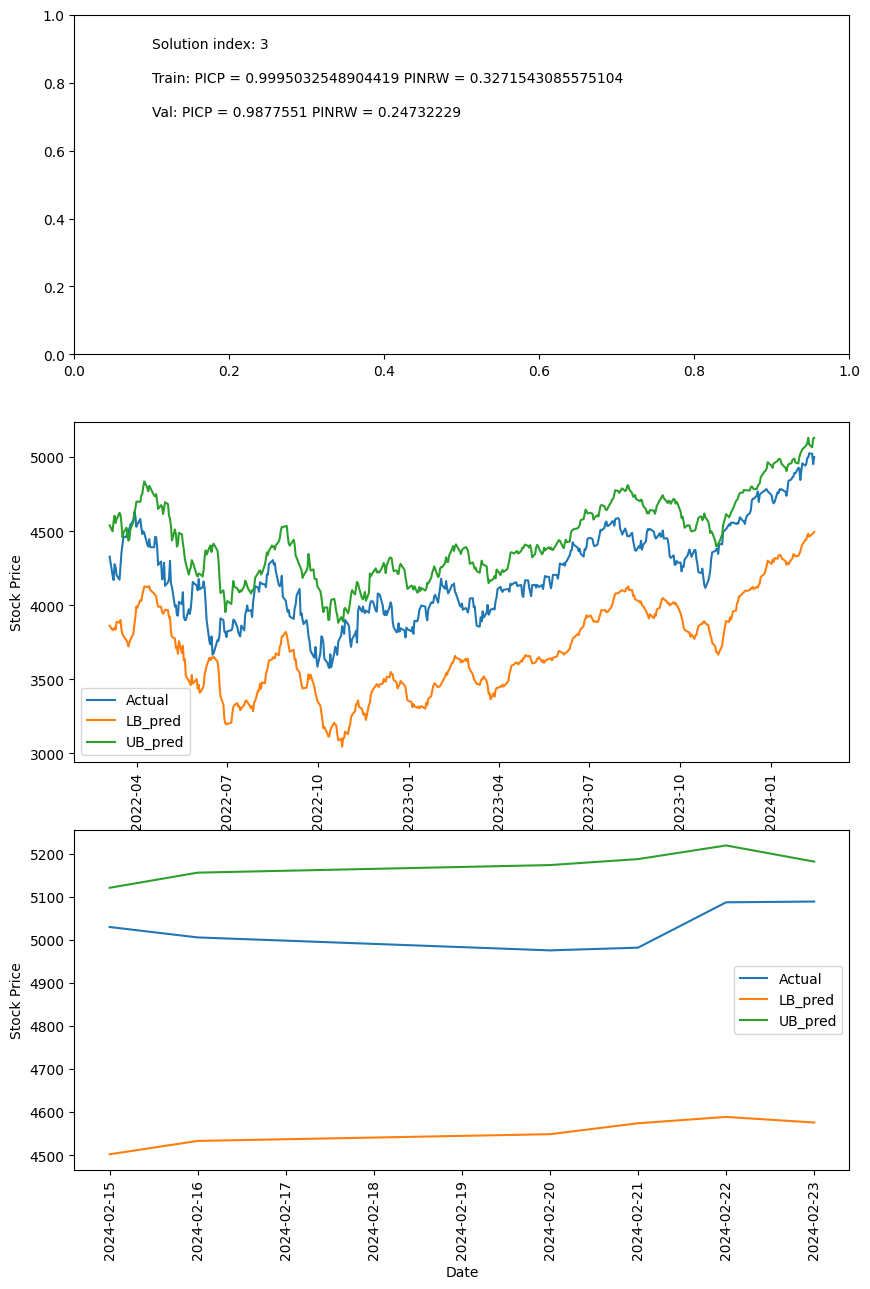

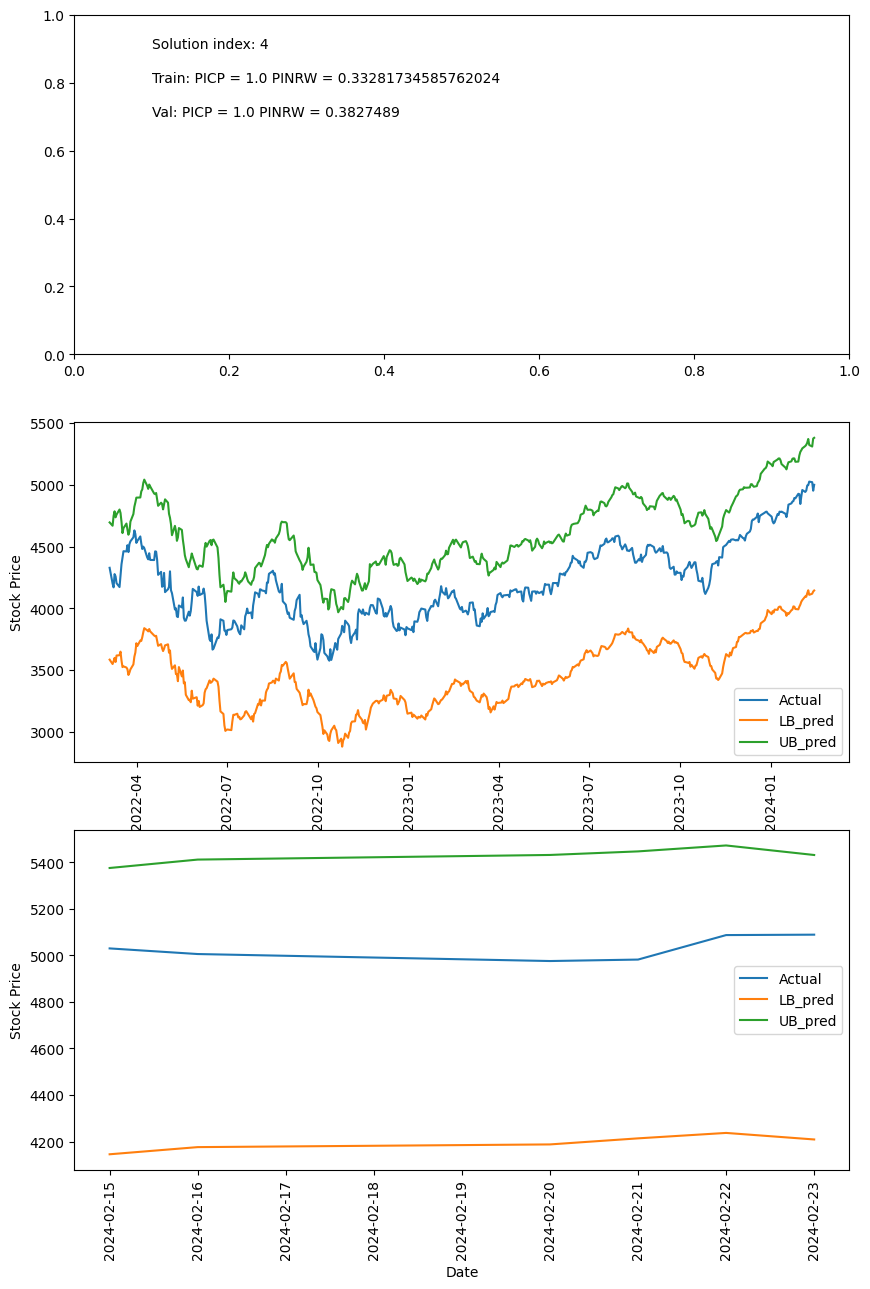

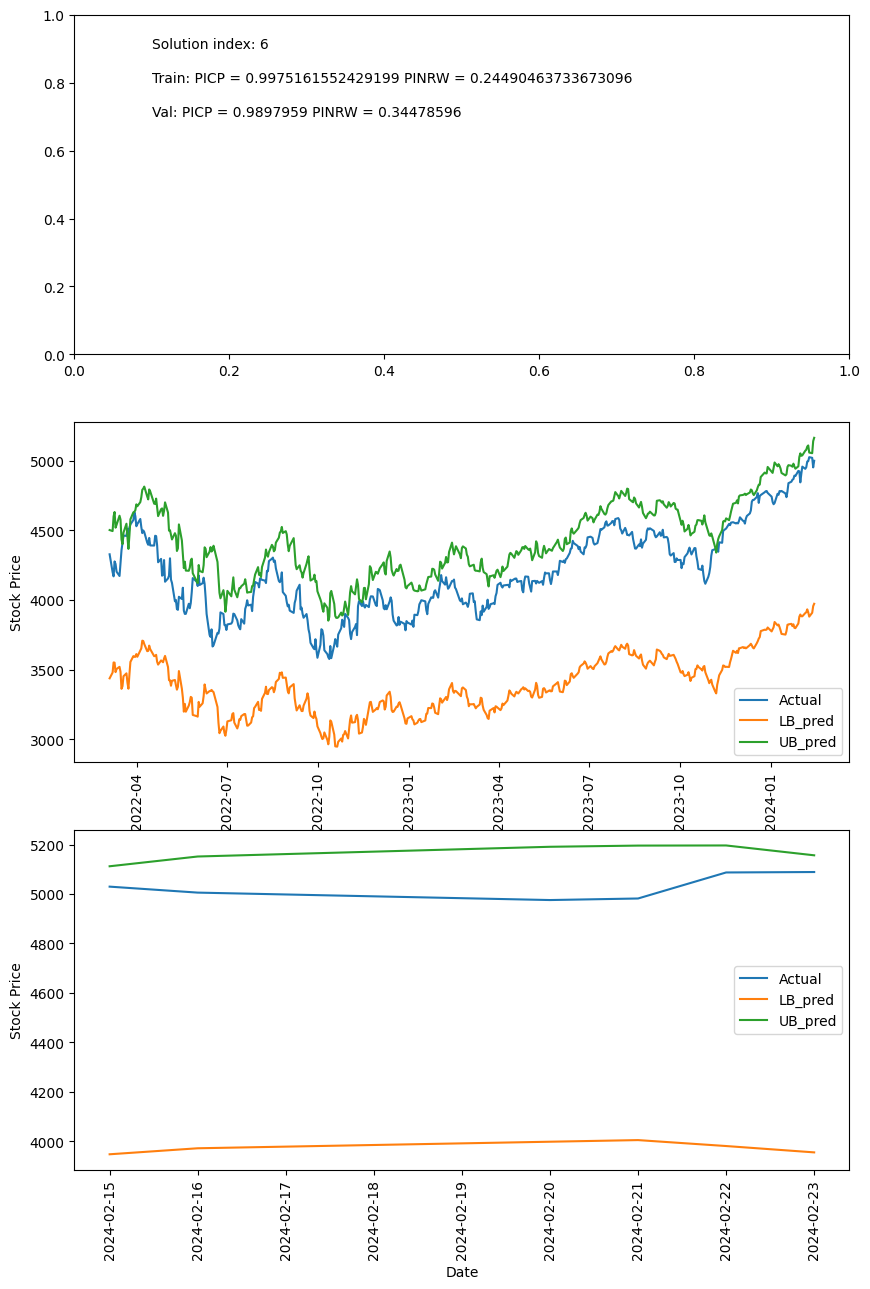

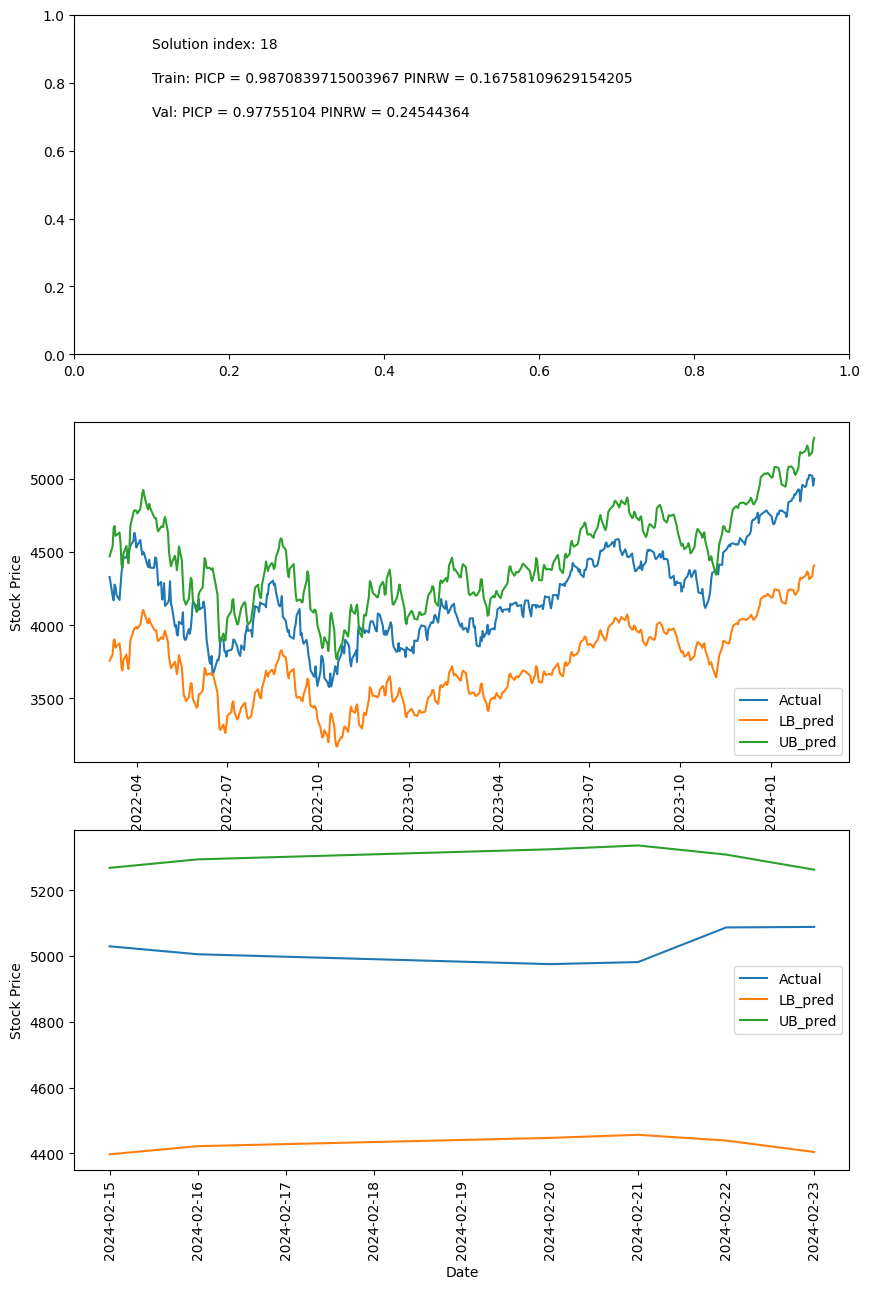

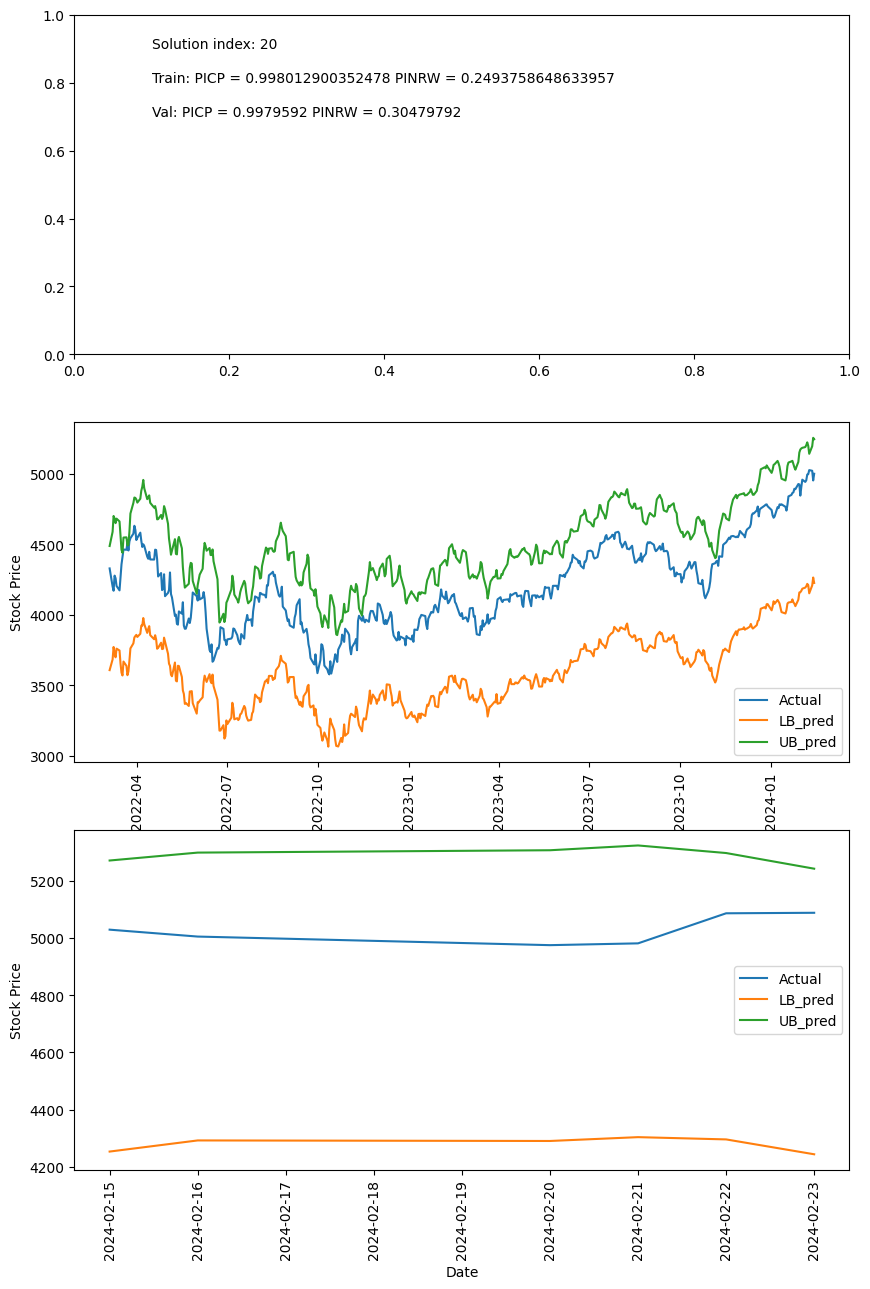

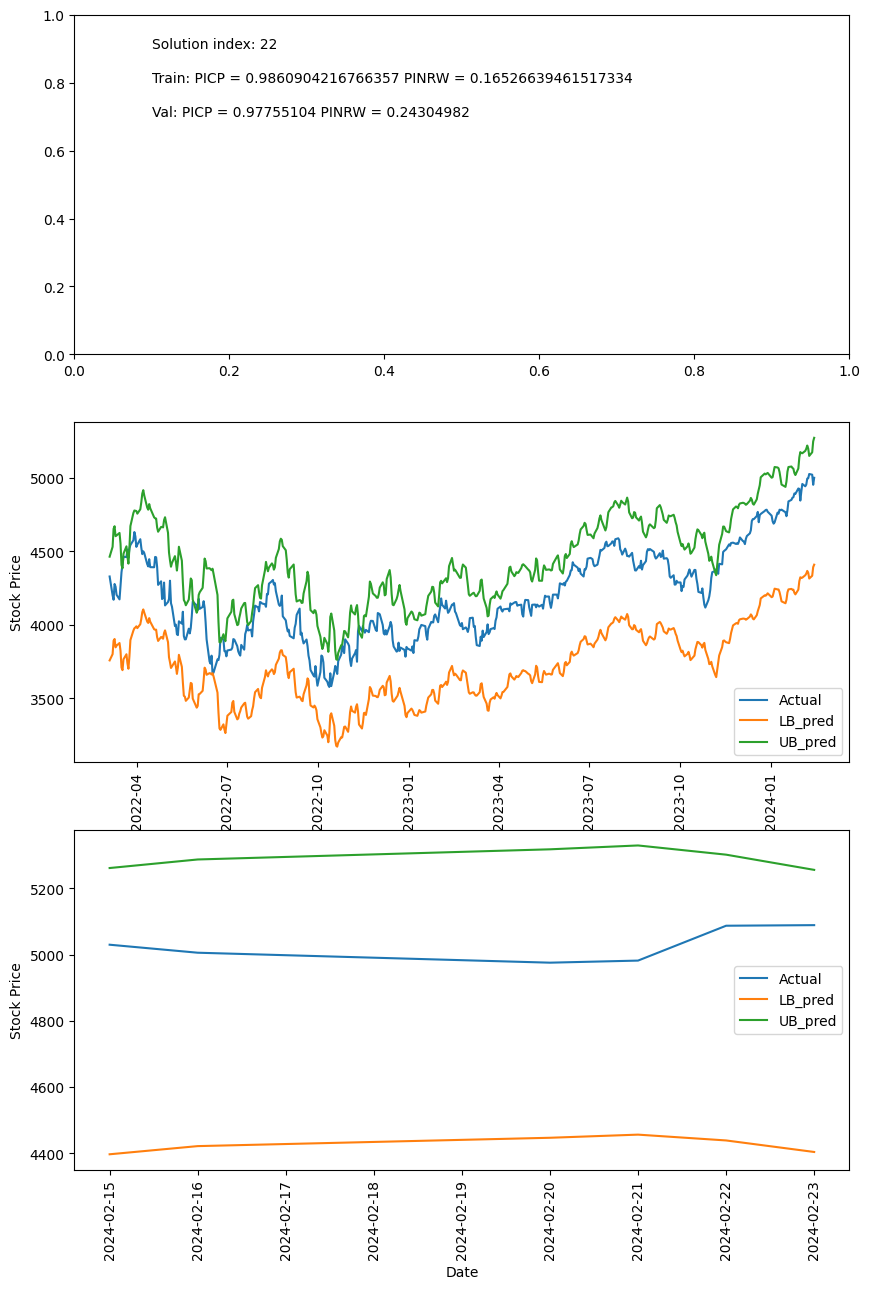

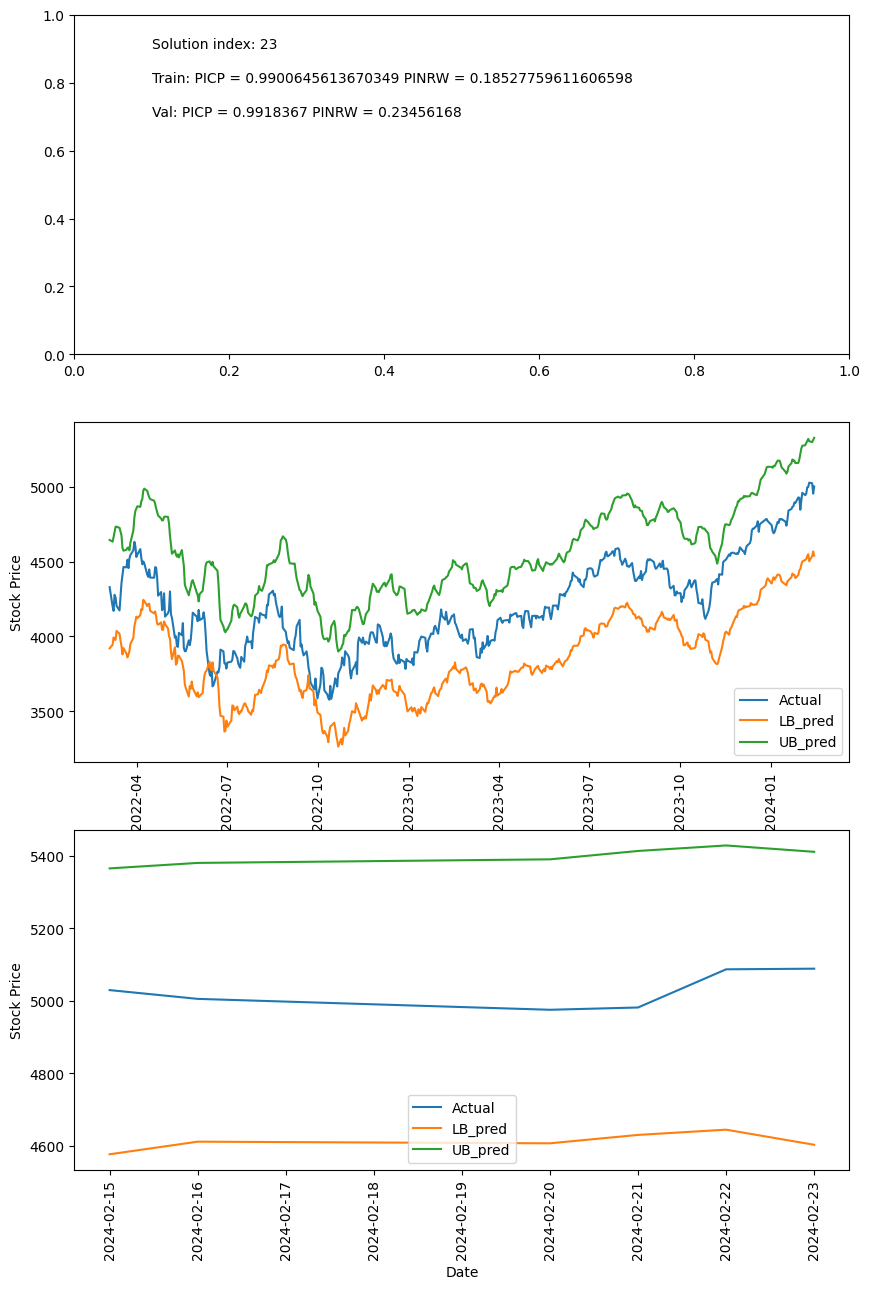

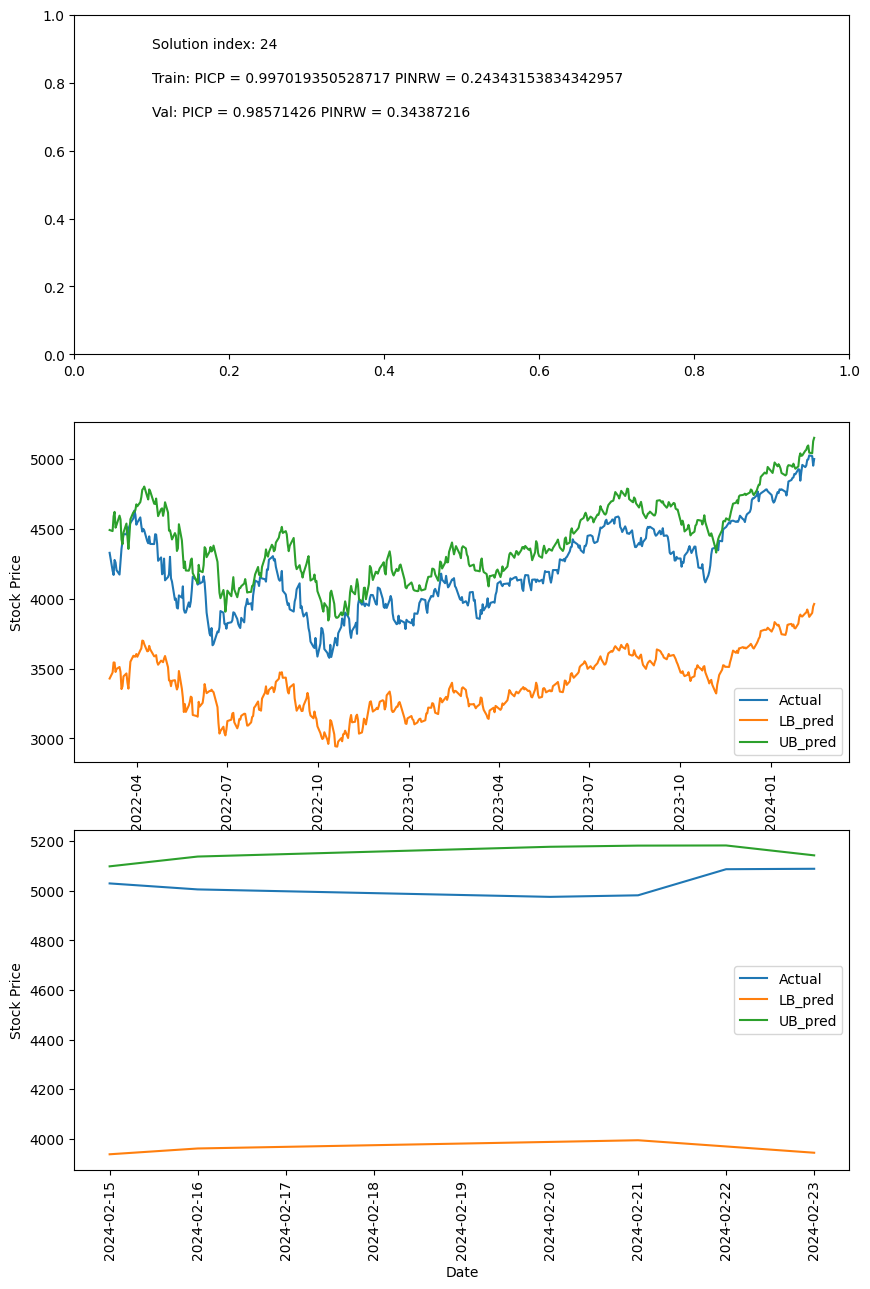

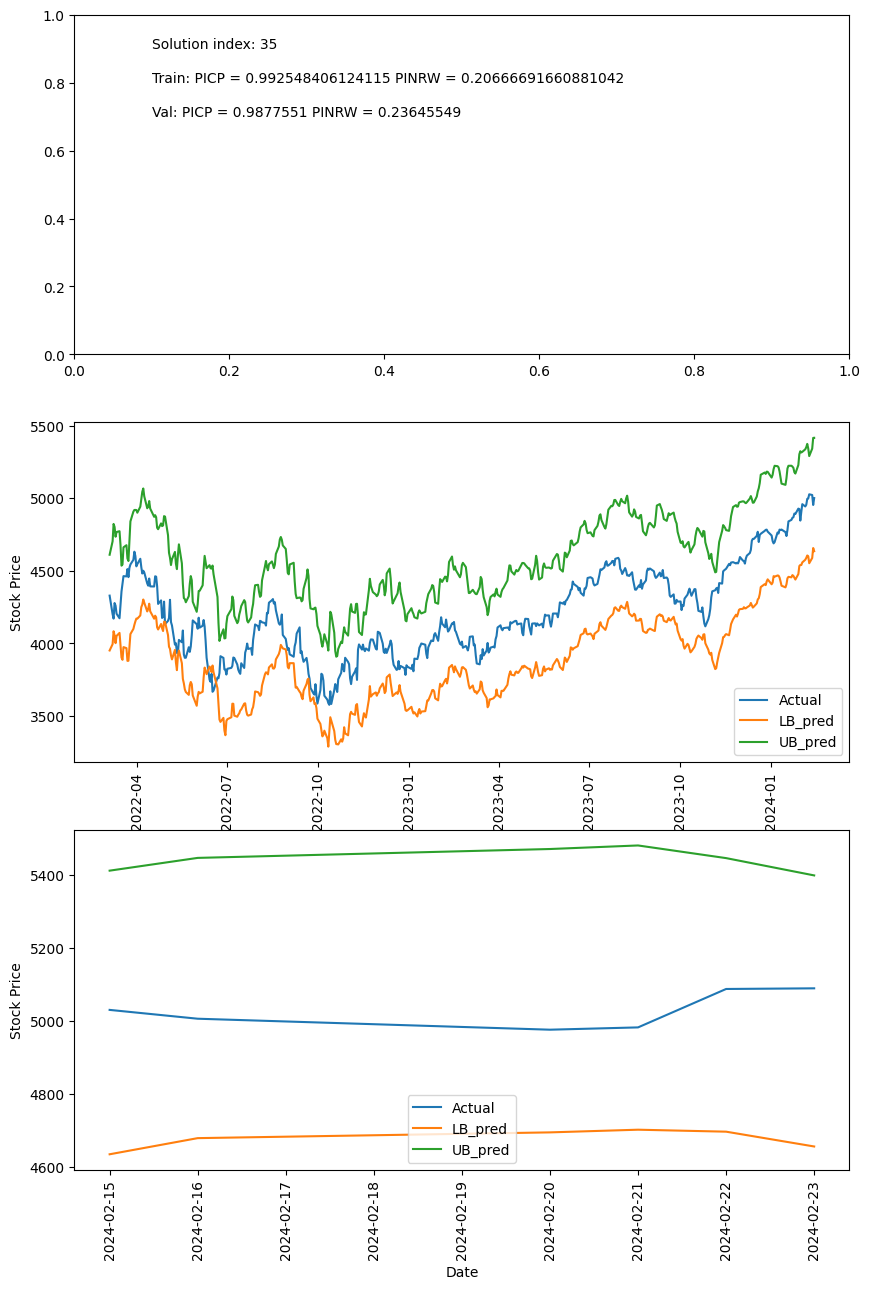

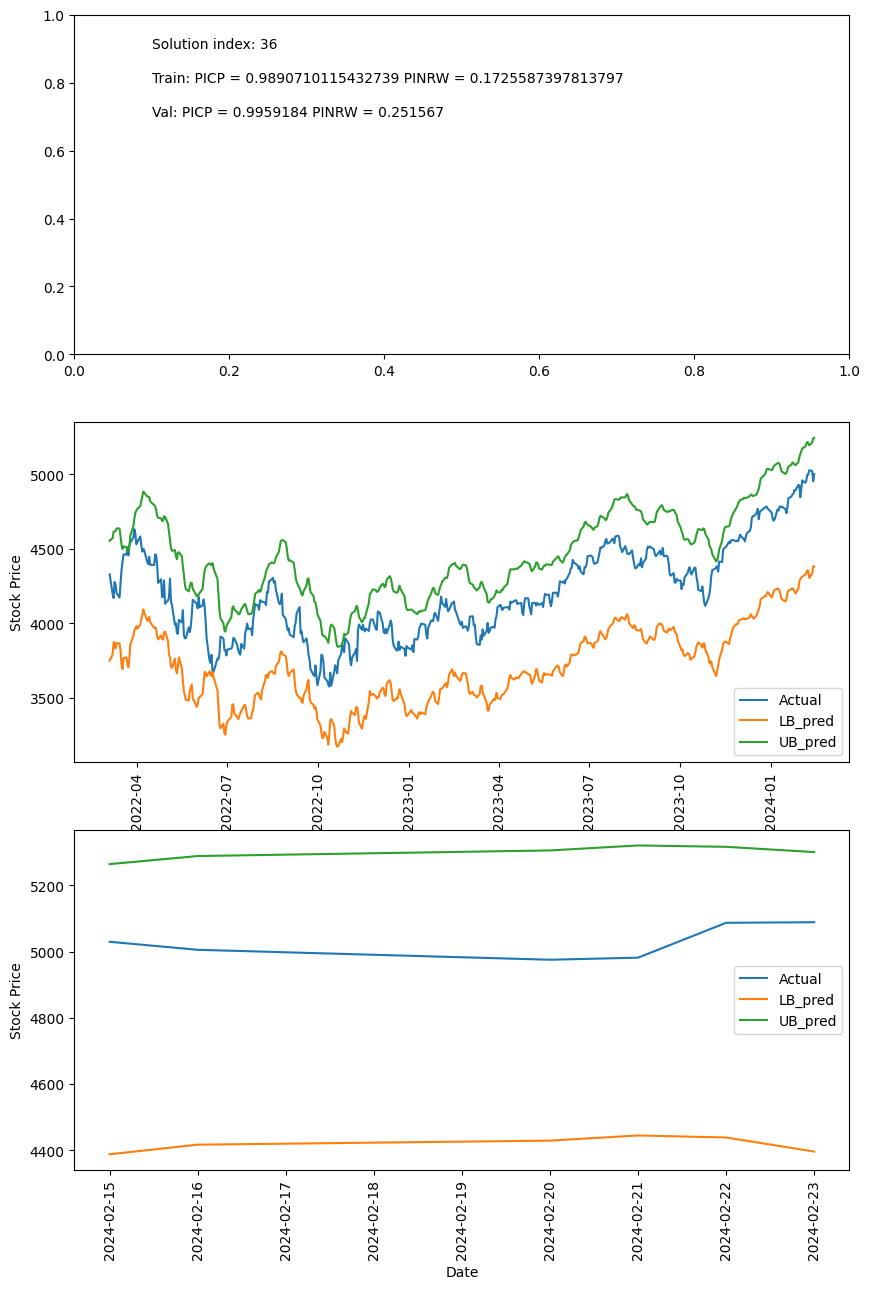

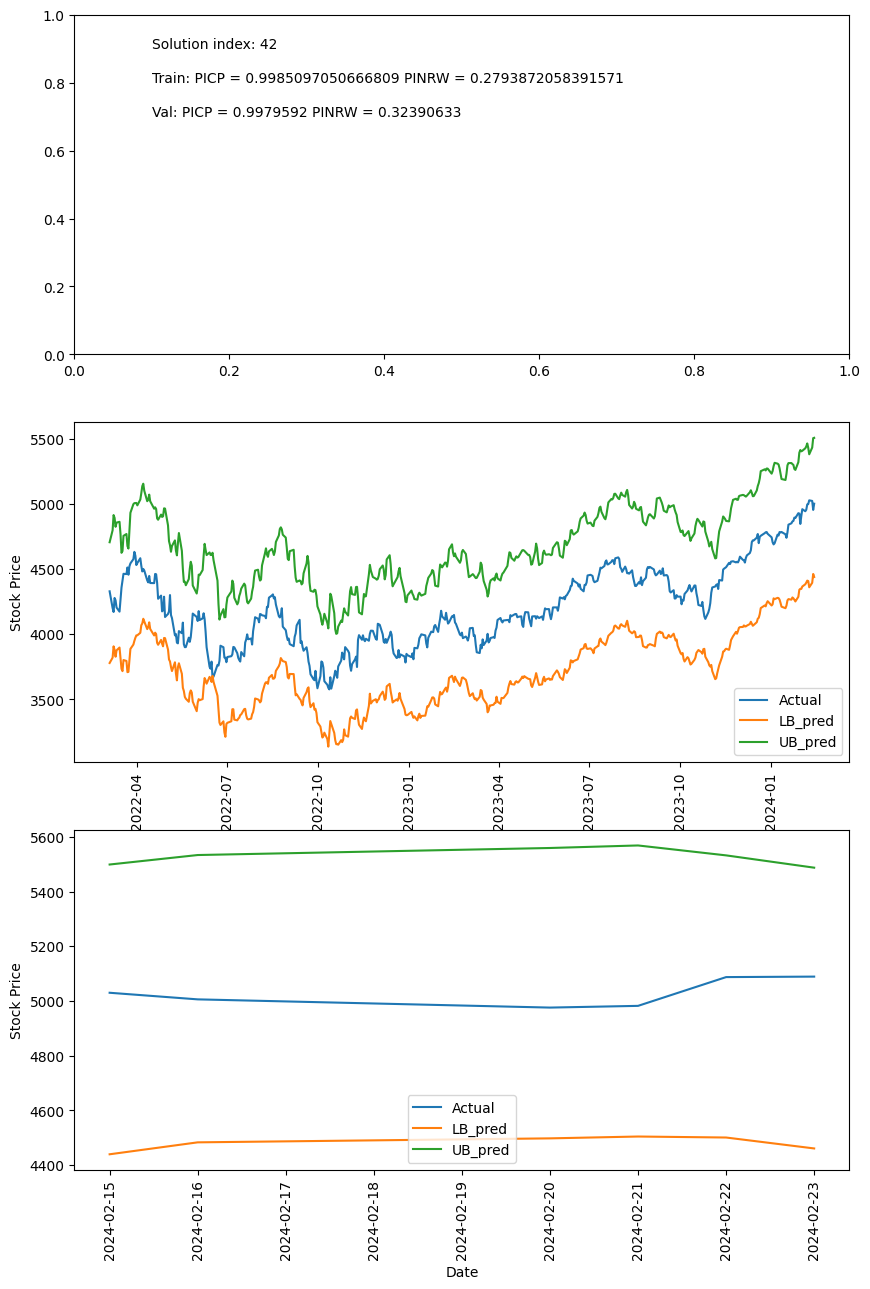

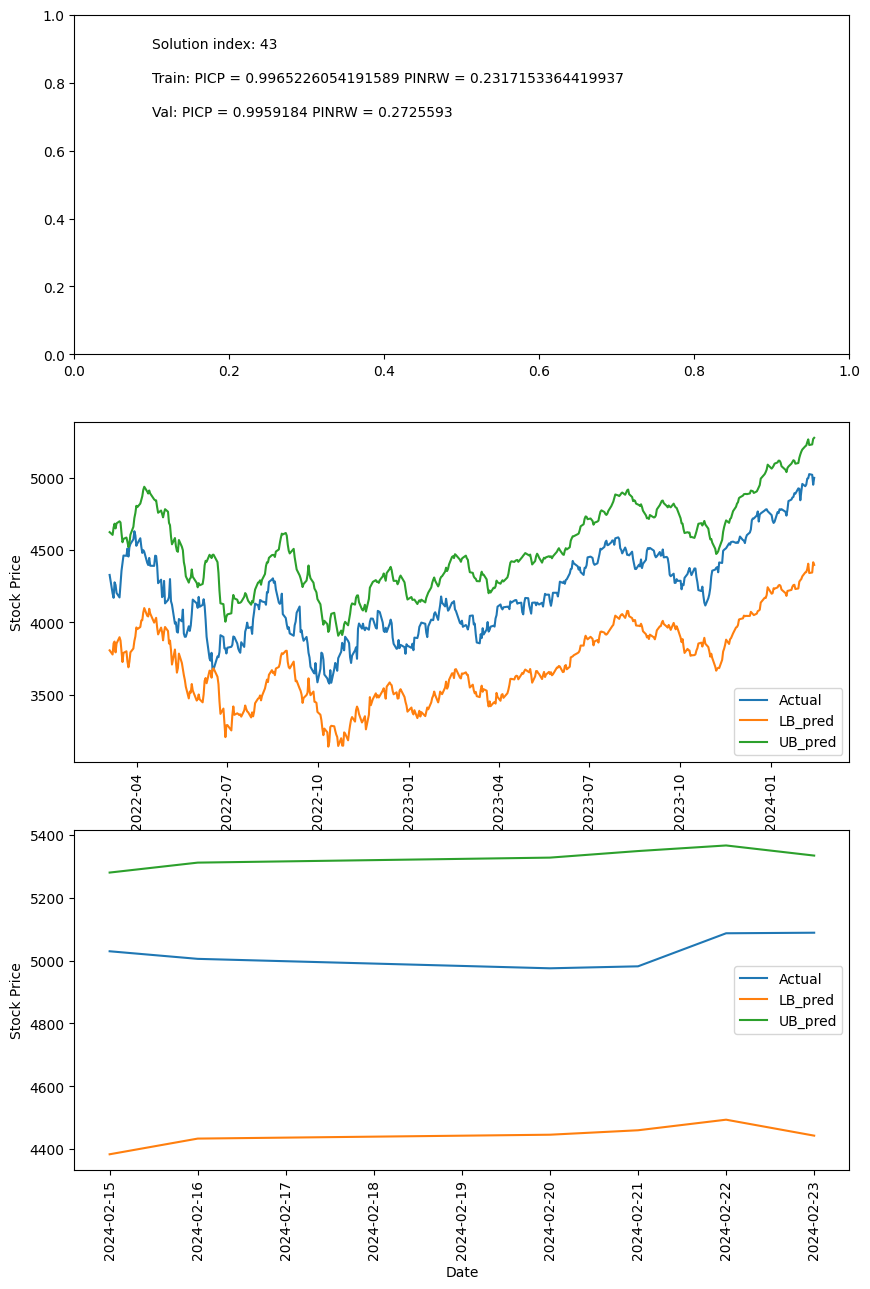

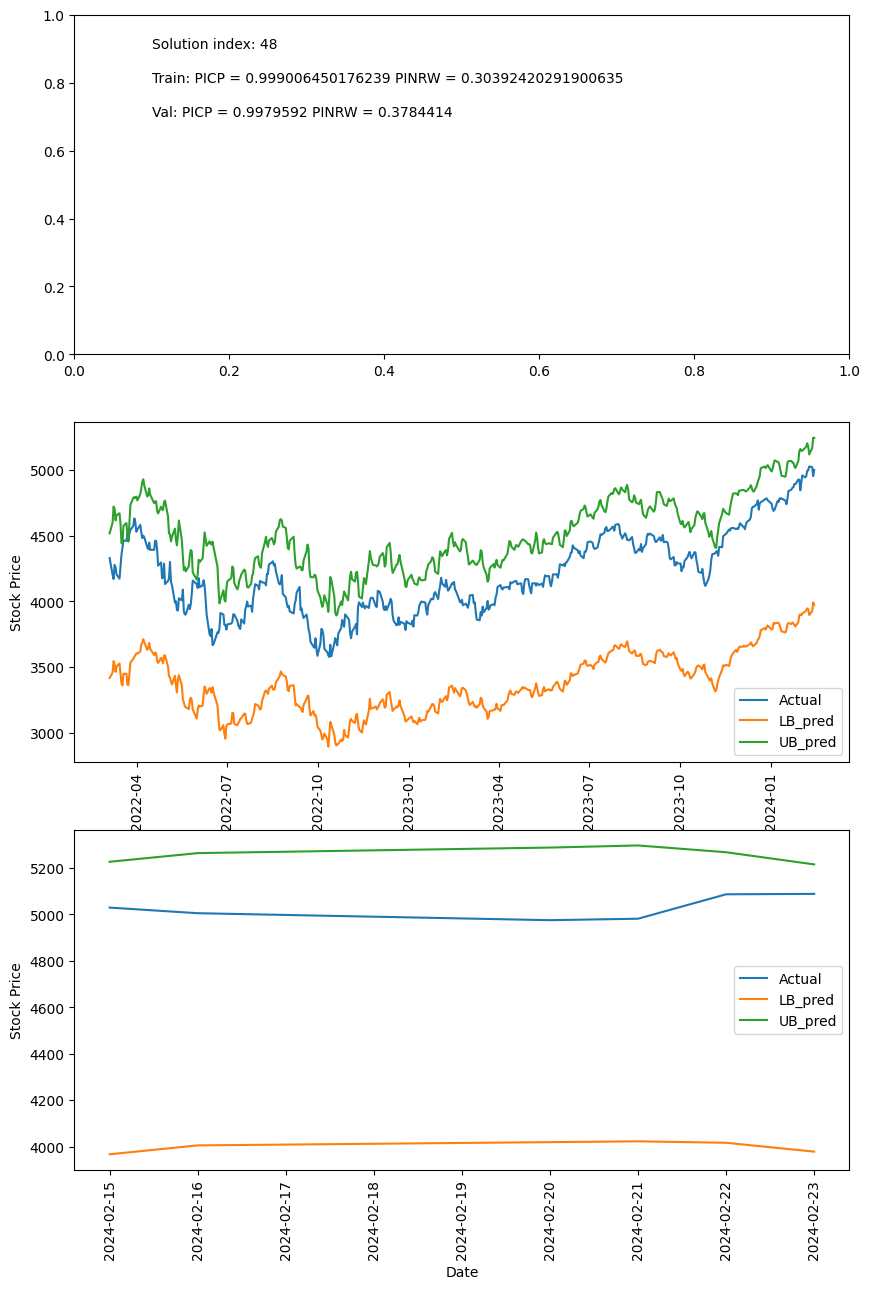

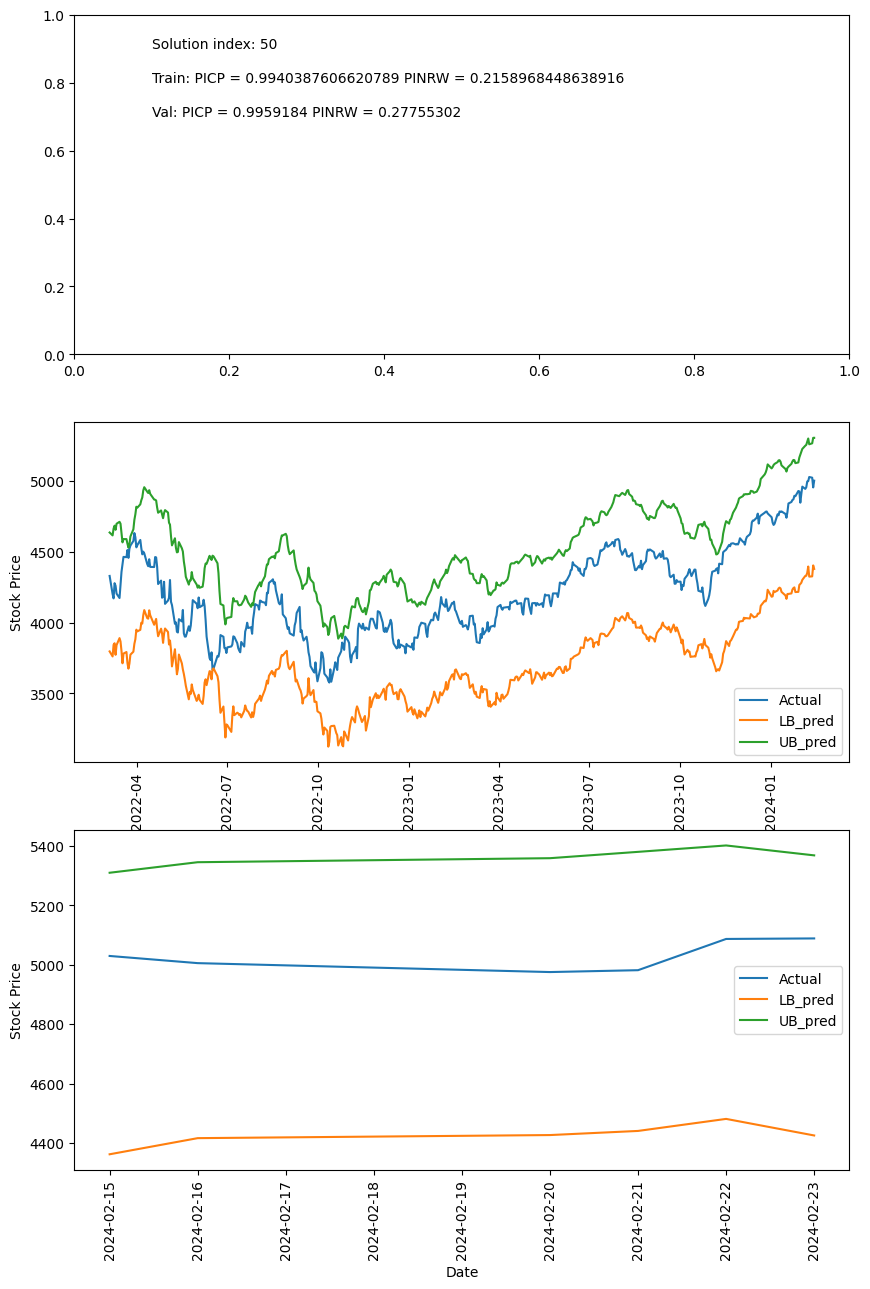

In [58]:
PICP_val = []
PINRW_val = []

with PdfPages('s&p_report_6_days_ahead.pdf') as pdf:
    for sol_ind in range(len(X)):
        model.set_weights(set_shape(X[sol_ind],shape))
        y_pred = model.predict(X_val, verbose = False)
        PICP_t = PICP(y_val, y_pred).numpy()
        PINRW_t = PINRW(y_pred).numpy()

        PICP_val.append(PICP_t)
        PINRW_val.append(PINRW_t)
        
        
        if PICP_t >= 0.97:

            y_pred = scaler.inverse_transform(y_pred)

            fig, axs = plt.subplots(3, 1, figsize=(10, 15))

            # Add text to the plot
            axs[0].text(0.1, 0.9, 'Solution index: ' + str(sol_ind))
            axs[0].text(0.1, 0.8, 'Train: PICP = ' + str(1 - F[sol_ind, 0]) + ' PINRW = ' + str(F[sol_ind, 1]))
            axs[0].text(0.1, 0.7, 'Val: PICP = ' + str(PICP_t) + ' PINRW = ' + str(PINRW_t))

            # Plot the actual and predicted stock prices with the upper and lower bounds
            axs[1].plot(test['Date'][11:-6], y_test_unscaled[:-6], label='Actual')
            axs[1].plot(test['Date'][11:-6], y_pred[:,0], label='LB_pred')
            axs[1].plot(test['Date'][11:-6], y_pred[:,1], label='UB_pred')
            axs[1].legend()
            axs[1].set_xlabel('Date')
            axs[1].set_ylabel('Stock Price')


            plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)

            # Predict and plot the future six days
            y_pred_future = model.predict(X_future, verbose = False)
            y_pred_future = scaler.inverse_transform(y_pred_future)
            axs[2].plot(last_dates, y_future, label='Actual')
            axs[2].plot(last_dates, y_pred_future[:,0], label='LB_pred')
            axs[2].plot(last_dates, y_pred_future[:,1], label='UB_pred')
            axs[2].legend()
            axs[2].set_xlabel('Date')
            axs[2].set_ylabel('Stock Price')
            plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=90)

            # Save the figure to a PDF
            pdf.savefig(fig) 

            plt.show()

In [49]:
metrics_df = pd.DataFrame({'PICP_train': 1 - F[:, 0], 'PINRW_train': F[:, 1], 'PICP_test': PICP_test, 'PINRW_test': PINRW_test})


NameError: name 'PICP_test' is not defined

In [50]:
metrics_df.to_csv('metrics.csv')

NameError: name 'metrics_df' is not defined

In [51]:
picp_diff_values = 1 - F[:,0] - PICP_test

# Создаем гистограмму
plt.hist(picp_diff_values, bins=np.arange(-0.3, 1, 0.1), align='left')

plt.xlabel('PICP_diff Values')
plt.ylabel('Number of solutions')
plt.title('Histogram of PICP_diff Values')

# Отображаем гистограмму
plt.show()

NameError: name 'PICP_test' is not defined

In [52]:
pinrw_diff_values = F[:, 1] - PINRW_test

# Создаем гистограмму
plt.hist(pinrw_diff_values, bins=np.arange(-0.1, 0.1, 0.01), align='left')

plt.xlabel('PINRW_diff Values')
plt.ylabel('Number of solutions')
plt.title('Histogram of PINRW_diff Values')

# Отображаем гистограмму
plt.show()

NameError: name 'PINRW_test' is not defined